# Compulsory Assignment 1
## Machine Learning and Deep Learning (CDSCO2041C)
Group: MLS26_CA01

Student IDs: 185912, 160363, xxx & xxx

Dataset: `greenhouse-gas-emissions.xlsx` (sheet `UK_by_source`)

### Question 1

1. Write a Python program to perform a covariance- and correlation-based analysis to examine
relationships between emissions, sources, and activities across years. Do not use any built-in
covariance or correlation functions. You must implement your calculations.

2. Write another Python program to visualise your findings from the previous step and briefly
explain the observed emission patterns. Hints: You may consider using histograms, boxplots,
and scatterplots

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
file_path = "/Users/pontusneumann/Desktop/greenhouse-gas-emissions.xlsx" # On the desctop, change username if needed

# Load sheets
sheet2 = pd.read_excel(file_path, sheet_name=1)  # Variable descriptions
sheet3 = pd.read_excel(file_path, sheet_name=2)  # Emission data

In [3]:
# Inspect variable descriptions

# Clean column names
sheet2.columns = sheet2.columns.str.strip()

# Relevant columns only
variables_table = sheet2.iloc[:, :2]
variables_table.columns = ["Variable", "Description"]
variables_table

,Variable,Description
0,Included in UK territorial total,Identifies emissions included in the UK territ...
1,Included in UK UNFCCC total,Identifies emissions included in the territori...
2,Included in UK Paris Agreement total,Identifies emissions included in the territori...
3,GHG,"The greenhouse gas emitted, with different spe..."
4,GHG grouped,"The greenhouse gas emitted, with F-gases group..."
5,CRT category,Categories defined in international guidelines...
6,CRT category description,Text description for each CRT category.
7,Year,The calendar year in which the emissions occur...
8,Territory name,"The territory where the emissions occurred, ei..."
9,Territorial Emissions Statistics sector,A grouping of the TES subsectors and categories.


In [4]:
# Initial Dataset Overview

# Basic shape of dataset
print("Rows, columns:", sheet3.shape)

# Year coverage
print("Years:", sheet3["Year"].min(),
      "→", sheet3["Year"].max(),
      "| n =", sheet3["Year"].nunique())

# Structural overview
print("Unique sectors:",
      sheet3["Territorial Emissions Statistics sector"].nunique())

print("Unique subsectors:",
      sheet3["Territorial Emissions Statistics subsector"].nunique())

print("Unique sources:",
      sheet3["Source"].nunique())

print("Unique fuel groups:",
      sheet3["Fuel group"].nunique())

# Missing values check
print("Missing emission values:",
      sheet3["Emissions (MtCO2e)"].isna().sum())

sheet3.info()
sheet3.describe()

Rows, columns: (78022, 15)
Years: 1990 → 2024 | n = 35
Unique sectors: 9
Unique subsectors: 28
Unique sources: 700
Unique fuel groups: 5
Missing emission values: 0
<class 'pandas.DataFrame'>
RangeIndex: 78022 entries, 0 to 78021
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Included in UK territorial total            78022 non-null  str    
 1   GHG                                         78022 non-null  str    
 2   GHG grouped                                 78022 non-null  str    
 3   CRT category                                78022 non-null  str    
 4   CRT category description                    78022 non-null  str    
 5   Year                                        78022 non-null  int64  
 6   Territory name                              78022 non-null  str    
 7   Territorial Emissions Statistics sector     78022 non-null  str    
 8   Ter

,Year,Emissions (MtCO2e)
count,78022.000000,78022.000000
mean,2007.771295,0.293069
std,9.982078,3.036902
min,1990.000000,-18.002028
25%,1999.000000,0.000124
50%,2008.000000,0.002087
75%,2016.000000,0.026358
max,2024.000000,184.014756


## Restricting the Analysis to Policy-Relevant Emissions

UK Carbon Budgets and official progress assessments are based on **territorial emissions**, meaning emissions that occur within the UK’s geographic boundaries. To ensure that the statistical analysis is aligned with the policy framework and carbon accounting methodology, we restrict the dataset to observations included in the *UK territorial total*.

This step ensures that subsequent covariance and correlation results reflect structurally relevant emission dynamics rather than memo items or internationally reported components that are treated separately in climate policy.


In [5]:
territorial = sheet3[
    sheet3["Included in UK territorial total"].str.lower() == "yes"
].copy()

print("Rows after territorial filter:", territorial.shape)

Rows after territorial filter: (75659, 15)


## Aggregating Emissions by Year and Sector

Rather than analysing hundreds of highly granular emission sources, we aggregate emissions to the top-level *Territorial Emissions Statistics sectors*. This aggregation improves interpretability, reduces dimensionality, and ensures that the covariance structure captures meaningful sector-level relationships rather than noise from very small individual sources. The sector-level aggregation reflects structured combinations of underlying sources and activities. Each sector is composed of multiple emission sources and fuel or activity categories, meaning that sectoral time series capture broader structural emission dynamics rather than isolated micro-level processes.

In [6]:
SECTOR_COL = "Territorial Emissions Statistics sector"

sector_year = (
    territorial
    .groupby(["Year", SECTOR_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

sector_year.head()

,Year,Territorial Emissions Statistics sector,Emissions (MtCO2e)
0,1990,Agriculture,54.988754
1,1990,Buildings and product uses,109.492561
2,1990,Domestic transport,124.191169
3,1990,Electricity supply,203.990902
4,1990,Fuel supply,77.192227


## Reshaping the Data to Wide Format (Years × Sectors)

To perform covariance and correlation analysis, the data must be structured so that each sector represents a separate variable observed over time. We therefore pivot the dataset into wide format, where rows represent years, columns represent sectors, and the values correspond to total annual emissions.

In this structure, each column becomes a sector-specific emission time series, allowing us to examine how sectors co-move and evolve across years.

In [7]:
pivot_sec = (
    sector_year
    .pivot(index="Year",
           columns=SECTOR_COL,
           values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

print("Shape of sector-level dataset:", pivot_sec.shape)
pivot_sec.head()

Shape of sector-level dataset: (35, 8)


Territorial Emissions Statistics sector,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Year,,,,,,,,
1990,54.988754,109.492561,124.191169,203.990902,77.192227,155.662400,10.266883,55.039201
1991,54.800121,121.292199,122.552535,200.562839,78.080868,156.665141,9.772005,56.836696
1992,54.457877,117.743777,123.850246,188.466186,79.240850,149.650442,8.962862,58.000423
1993,53.561508,121.671071,124.995984,170.963203,78.927561,143.356940,8.401128,59.475666
1994,54.320493,116.627834,125.175291,166.731982,71.448923,145.437790,7.925957,60.982346


## Custom Covariance and Correlation (No Built-in Functions)

In this section, we manually implement the sample covariance and correlation formulas to examine the relationships between emission sources across years. This approach ensures full transparency of the statistical calculations and demonstrates a clear understanding of the underlying theoretical foundations from Lecture 02.

### Sample Mean

For a variable ( x ) with ( n ) observations:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i
$$

The mean represents the central tendency of emissions across years.

### Sample Covariance

The sample covariance between two variables ( x ) and ( y ) is defined as:

$$
\text{cov}(x,y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

We use **(n−1)** instead of **n** because we compute the *sample covariance*, not the population covariance. This correction ensures an unbiased estimator.

* **Positive covariance** → Two emission sources increase or decrease together over time.
* **Negative covariance** → When one source increases, the other tends to decrease.
* **Covariance close to zero** → No clear linear co-movement.

However, covariance depends on the scale of the variables. Large emission sectors will naturally produce larger covariance values.

### Sample Standard Deviation

Standard deviation is derived from variance:

$$
s_x = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n}(x_i - \bar{x})^2}
$$

It measures dispersion of emissions over time.

### Sample Correlation

Correlation standardizes covariance:

$$
\text{corr}(x,y) = \frac{\text{cov}(x,y)}{s_x s_y}
$$

Unlike covariance, correlation is **scale-independent** and bounded between -1 and 1.

* +1: Perfect positive linear relationship
* -1: Perfect negative linear relationship
* 0: No linear relationship

In our greenhouse gas dataset, correlation helps identify:

* Which sectors structurally decline together
* Whether reductions are economy-wide or sector-specific
* Whether certain sources behave independently

### Application for our Emission Analysis

Understanding covariance and correlation allows us to:

* Detect structural transformation in the UK economy
* Identify co-movement between industrial sectors
* Evaluate whether emission reductions occur uniformly
* Support later clustering and policy interpretation

Covariance gives magnitude of joint variation.
Correlation gives strength and direction of relationship.


In [8]:
# We implement the sample mean, variance, standard deviation,
# covariance, and correlation manually (ddof = 1).

def mean(xs):
    xs = list(xs)
    return sum(xs) / len(xs)


def variance(xs, ddof=1):
    xs = list(xs)
    n = len(xs)
    if n <= ddof:
        return float("nan")
    m = mean(xs)
    return sum((x - m) ** 2 for x in xs) / (n - ddof)


def std(xs, ddof=1):
    v = variance(xs, ddof=ddof)
    return math.sqrt(v) if not math.isnan(v) else float("nan")


def covariance(xs, ys, ddof=1):
    xs, ys = list(xs), list(ys)
    n = len(xs)
    if n != len(ys) or n <= ddof:
        return float("nan")
    mx, my = mean(xs), mean(ys)
    return sum((x - mx) * (y - my) for x, y in zip(xs, ys)) / (n - ddof)


def correlation(xs, ys):
    cov = covariance(xs, ys, ddof=1)
    sx = std(xs, ddof=1)
    sy = std(ys, ddof=1)
    if sx == 0 or sy == 0 or math.isnan(cov):
        return float("nan")
    return cov / (sx * sy)

In [9]:
# Covariance and correlation matrices (sector-level)

sectors = pivot_sec.columns.tolist()

cov_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)
corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)

for s1 in sectors:
    for s2 in sectors:
        cov_matrix.loc[s1, s2] = covariance(
            pivot_sec[s1].values,
            pivot_sec[s2].values
        )
        corr_matrix.loc[s1, s2] = correlation(
            pivot_sec[s1].values,
            pivot_sec[s2].values
        )

print("Covariance matrix:")
display(cov_matrix.round(2))

Covariance matrix:


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,7.29,28.16,11.57,99.48,41.04,89.26,8.15,38.83
Buildings and product uses,28.16,173.11,67.56,575.03,181.78,373.71,31.81,193.37
Domestic transport,11.57,67.56,58.91,268.73,65.55,132.82,8.32,78.62
Electricity supply,99.48,575.03,268.73,2564.24,677.64,1408.67,118.14,677.31
Fuel supply,41.04,181.78,65.55,677.64,268.90,567.09,54.18,256.58
Industry,89.26,373.71,132.82,1408.67,567.09,1231.17,117.08,538.61
LULUCF,8.15,31.81,8.32,118.14,54.18,117.08,12.10,49.70
Waste,38.83,193.37,78.62,677.31,256.58,538.61,49.70,277.05


In [10]:
print("Correlation matrix:")
display(corr_matrix.round(3))

Correlation matrix:


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.793,0.558,0.728,0.927,0.942,0.867,0.864
Buildings and product uses,0.793,1.000,0.669,0.863,0.843,0.810,0.695,0.883
Domestic transport,0.558,0.669,1.000,0.691,0.521,0.493,0.312,0.615
Electricity supply,0.728,0.863,0.691,1.000,0.816,0.793,0.671,0.804
Fuel supply,0.927,0.843,0.521,0.816,1.000,0.986,0.950,0.940
Industry,0.942,0.810,0.493,0.793,0.986,1.000,0.959,0.922
LULUCF,0.867,0.695,0.312,0.671,0.950,0.959,1.000,0.858
Waste,0.864,0.883,0.615,0.804,0.940,0.922,0.858,1.000


In [11]:
# Year-over-year differences

diff_sec = pivot_sec.diff().dropna()

diff_corr_matrix = pd.DataFrame(index=sectors, columns=sectors, dtype=float)

for s1 in sectors:
    for s2 in sectors:
        diff_corr_matrix.loc[s1, s2] = correlation(
            diff_sec[s1].values,
            diff_sec[s2].values
        )

display(diff_corr_matrix.round(3))


,Agriculture,Buildings and product uses,Domestic transport,Electricity supply,Fuel supply,Industry,LULUCF,Waste
Agriculture,1.000,0.261,0.251,-0.101,-0.069,0.238,-0.185,-0.014
Buildings and product uses,0.261,1.000,0.033,0.389,0.044,0.205,-0.017,-0.049
Domestic transport,0.251,0.033,1.000,0.114,0.069,0.125,-0.094,0.180
Electricity supply,-0.101,0.389,0.114,1.000,-0.178,0.317,-0.098,-0.117
Fuel supply,-0.069,0.044,0.069,-0.178,1.000,-0.001,-0.049,0.244
Industry,0.238,0.205,0.125,0.317,-0.001,1.000,-0.043,0.055
LULUCF,-0.185,-0.017,-0.094,-0.098,-0.049,-0.043,1.000,-0.051
Waste,-0.014,-0.049,0.180,-0.117,0.244,0.055,-0.051,1.000


### Spurious trend issue acknowledgement
Because sectoral emissions exhibit strong long-run trends, correlations in levels partly reflect shared time dependence. To assess whether sectors co-move beyond common trends, we also analyse year-over-year changes.

In [12]:
# Correlation with Year (trend strength)

years = pivot_sec.index.values

corr_with_year = pd.Series({
    sector: correlation(years, pivot_sec[sector].values)
    for sector in sectors
}).sort_values()

display(corr_with_year.to_frame("corr(Year, sector_emissions)").round(3))


,"corr(Year, sector_emissions)"
Fuel supply,-0.992
Industry,-0.984
LULUCF,-0.937
Waste,-0.932
Agriculture,-0.927
Electricity supply,-0.863
Buildings and product uses,-0.856
Domestic transport,-0.549


Because covariance is scale-dependent, sectors with large emission levels and strong absolute changes over time, such as Electricity supply and Industry, exhibit substantially larger covariance values. In contrast, smaller sectors such as Agriculture generate lower covariance magnitudes, even when their correlations with other sectors remain high. This highlights that covariance reflects joint variability in absolute terms, whereas correlation provides a scale-independent measure of linear association.

### Additional Slice: Fuel Group Trajectories
Fuel groups represent a small number of energy categories, such as solid fuels, liquid fuels, and gaseous fuels. Analysing fuel-level emission trajectories provides a complementary perspective to sector-level analysis and helps identify structural shifts in the UK energy mix over time.

In [13]:
FUEL_COL = "Fuel group"

fuel_year = (
    territorial
    .groupby(["Year", FUEL_COL], as_index=False)["Emissions (MtCO2e)"]
    .sum()
)

pivot_fuel = (
    fuel_year
    .pivot(index="Year", columns=FUEL_COL, values="Emissions (MtCO2e)")
    .fillna(0.0)
    .sort_index()
)

fuel_cols = list(pivot_fuel.columns)
fuel_corr = pd.DataFrame(index=fuel_cols, columns=fuel_cols, dtype=float)

for a in fuel_cols:
    for b in fuel_cols:
        fuel_corr.loc[a, b] = correlation(pivot_fuel[a].values, pivot_fuel[b].values)

display(pivot_fuel.head())
display(fuel_corr.round(3))

corr_fuel_year = pd.Series({c: correlation(pivot_fuel.index.values, pivot_fuel[c].values) for c in fuel_cols}).sort_values()
display(corr_fuel_year.to_frame("corr(Year, fuel_group_emissions)").round(3))

Fuel group,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Year,,,,,
1990,221.201645,148.464106,209.842656,14.814075,196.501615
1991,223.790559,156.244617,209.894152,14.290065,196.343011
1992,209.220581,155.377805,205.279474,14.959005,195.535798
1993,179.702582,170.932214,200.649420,15.055283,195.013564
1994,167.372512,179.496265,197.686335,13.784836,190.310669


,Coal,Gaseous fuels,Other emissions,Other solid fuels,Petroleum
Coal,1.000,0.209,0.847,0.911,0.898
Gaseous fuels,0.209,1.000,0.195,0.178,0.272
Other emissions,0.847,0.195,1.000,0.968,0.949
Other solid fuels,0.911,0.178,0.968,1.000,0.949
Petroleum,0.898,0.272,0.949,0.949,1.000


,"corr(Year, fuel_group_emissions)"
Other emissions,-0.974
Other solid fuels,-0.972
Petroleum,-0.971
Coal,-0.925
Gaseous fuels,-0.289


## Visualisation of Emission Patterns

To complement the covariance and correlation analysis, we now visualise the emission trajectories across sectors and fuel groups. Visualisation allows us to examine time trends, variability, and distributional patterns more directly, and to assess whether the statistical relationships identified in the previous section are reflected in observable emission dynamics.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

COL_RED   = "#fa4d56"
COL_GREEN = "#6fdc8c"
COL_BLUE  = "#33b1ff"
COL_GRAY  = "#6b7280"
COL_DARK  = "#111827"

SECTOR_PALETTE = [COL_RED, COL_BLUE, COL_GREEN, "#ffb000", "#a56eff", "#ff7eb6", "#8a8f98", "#00bcd4"]

def set_clean_theme():
    sns.set_theme(
        style="white",  # crucial: not whitegrid
        context="notebook",
        rc={
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "axes.edgecolor": COL_DARK,
            "axes.labelcolor": COL_DARK,
            "text.color": COL_DARK,
            "xtick.color": COL_GRAY,
            "ytick.color": COL_GRAY,
            "axes.grid": False,   # hard off
            "grid.alpha": 0.0,
            "font.size": 10,
            "axes.titlesize": 13,
            "axes.labelsize": 11,
            "figure.dpi": 160,
            "savefig.dpi": 300,
        }
    )

def clean_ax(ax):
    ax.grid(False)
    sns.despine(ax=ax, top=True, right=True)
    ax.margins(x=0.01)
    ax.tick_params(labelsize=9)

set_clean_theme()

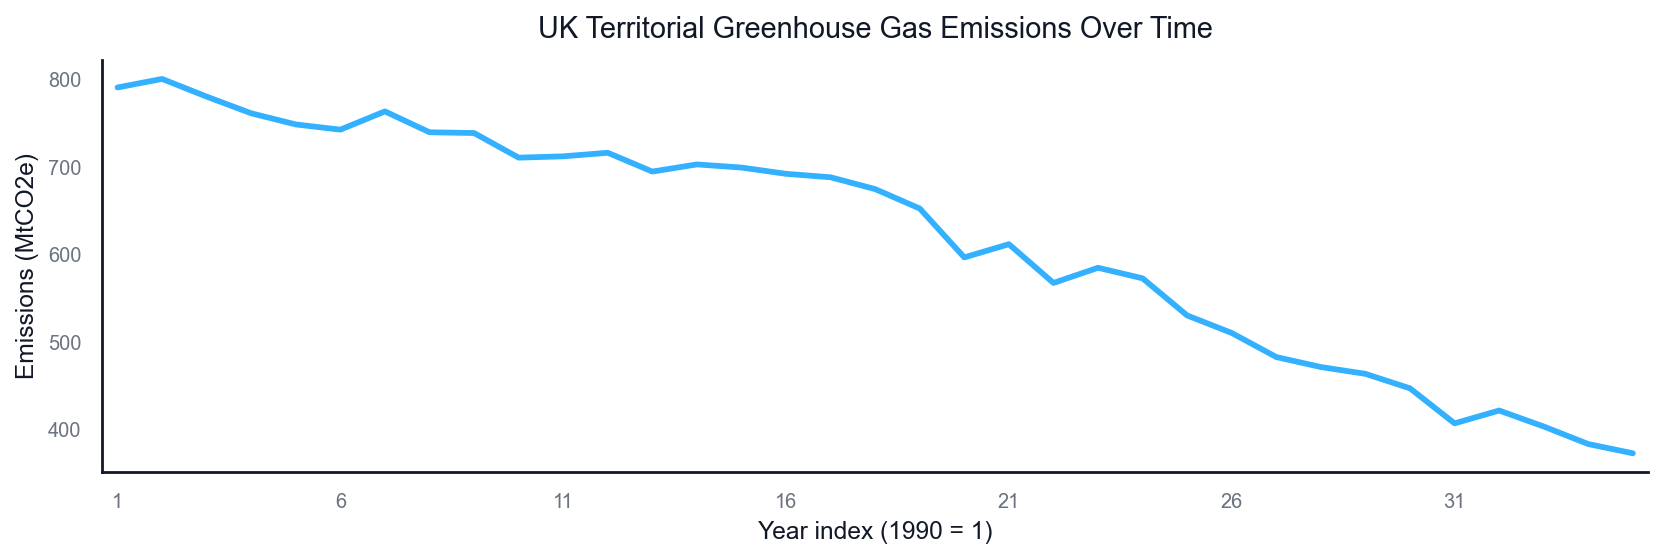

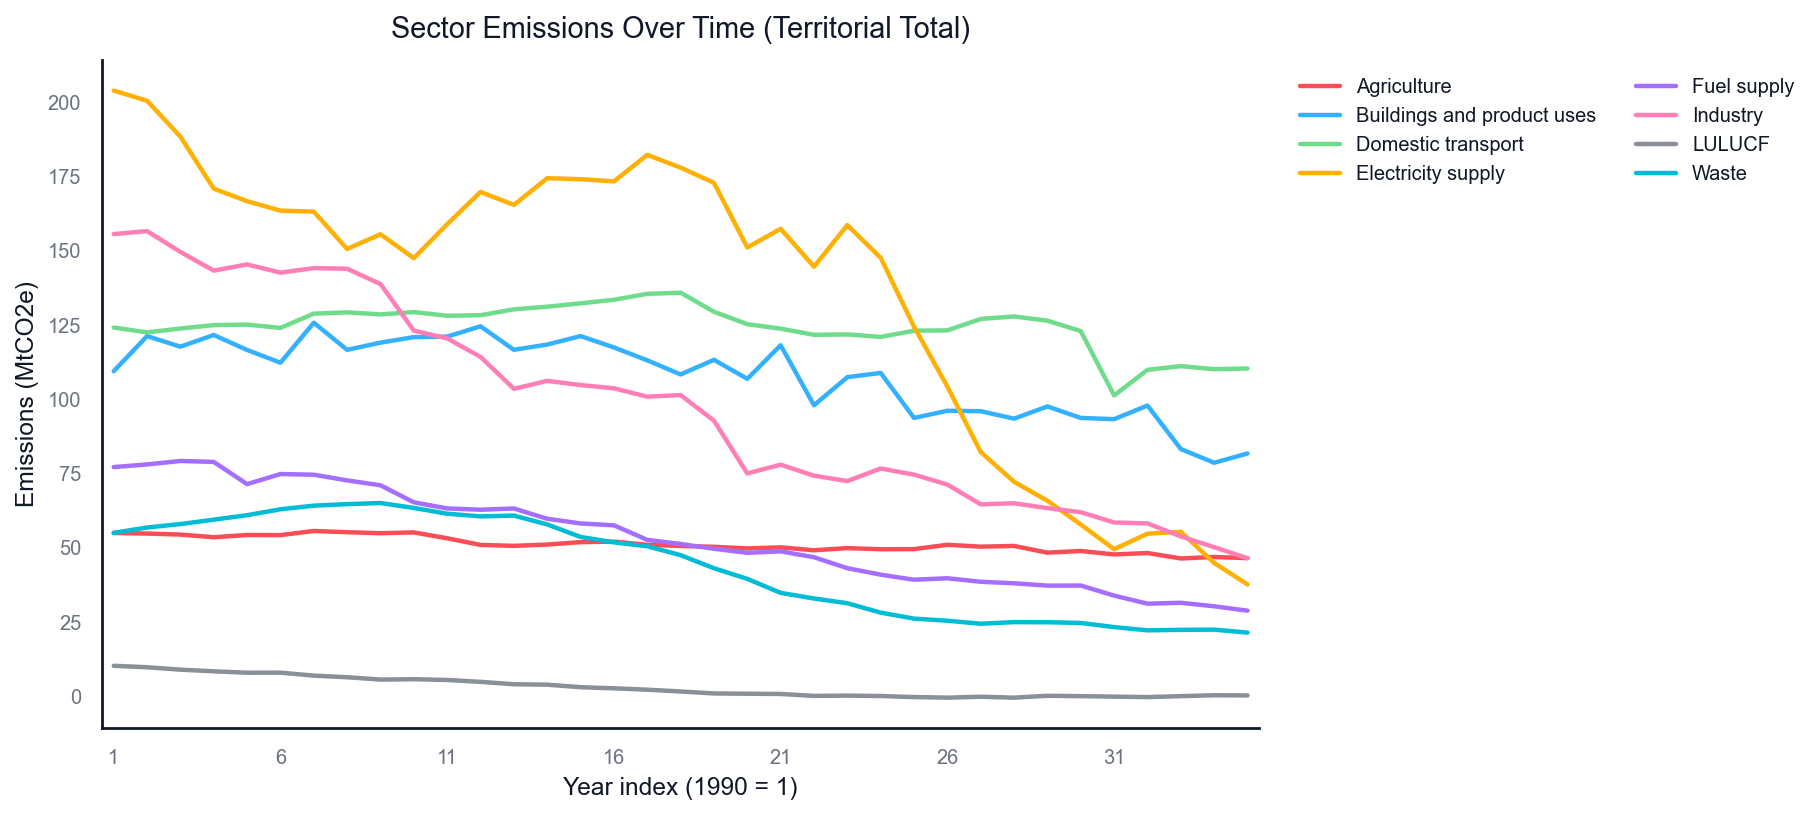

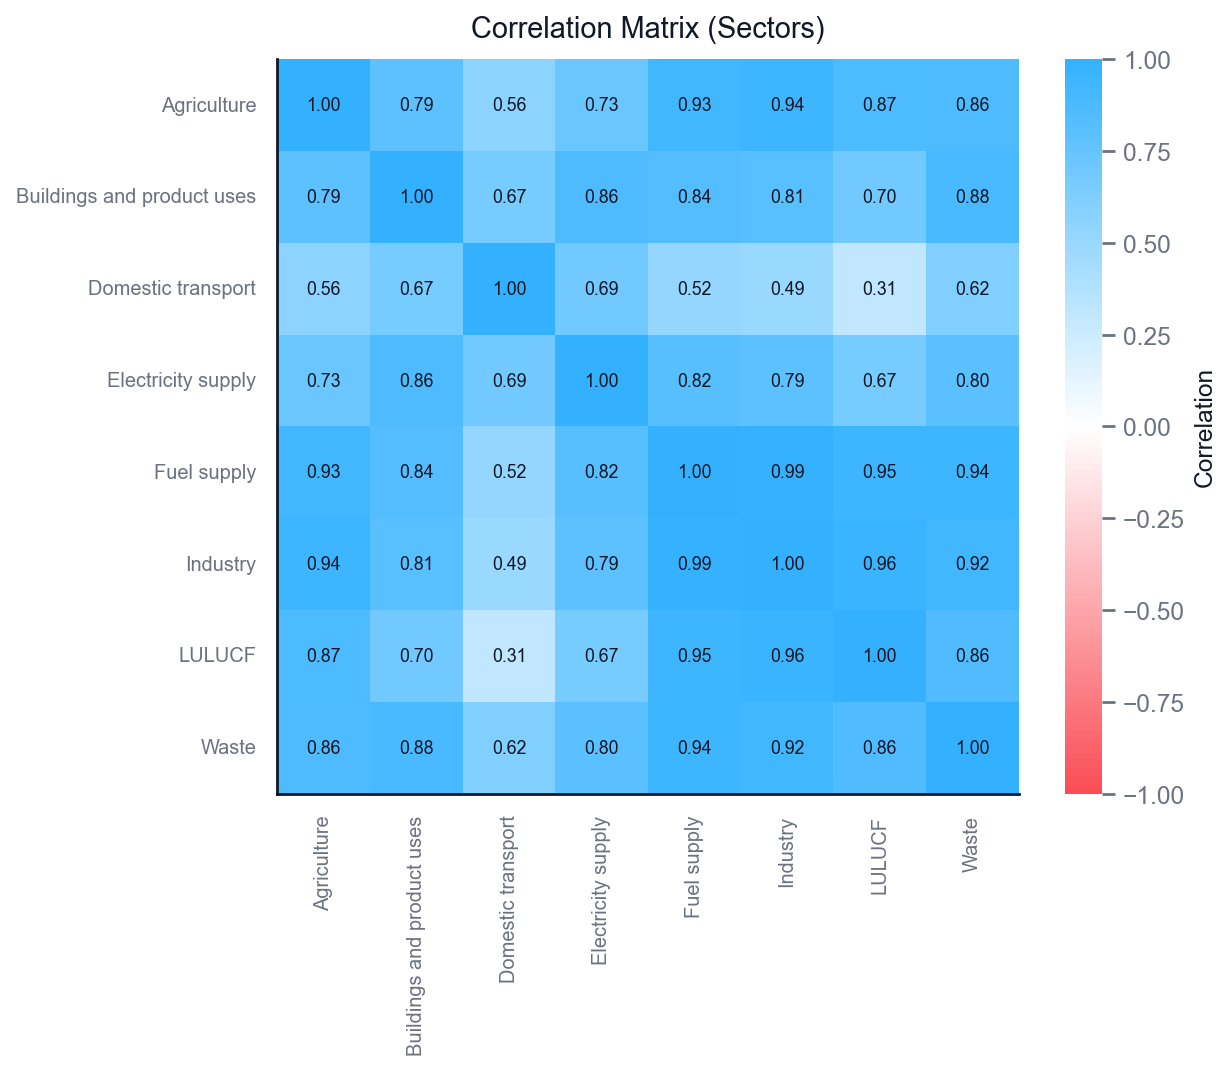

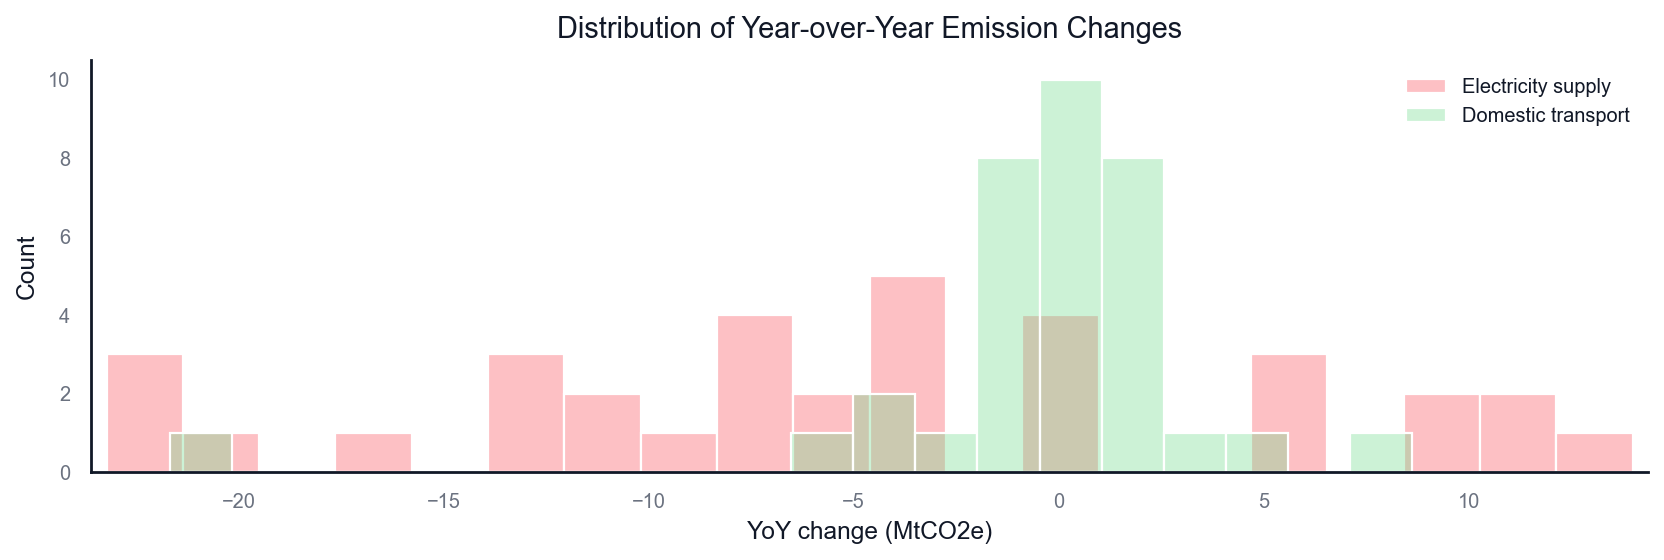

AttributeError: 'NoneType' object has no attribute 'remove'

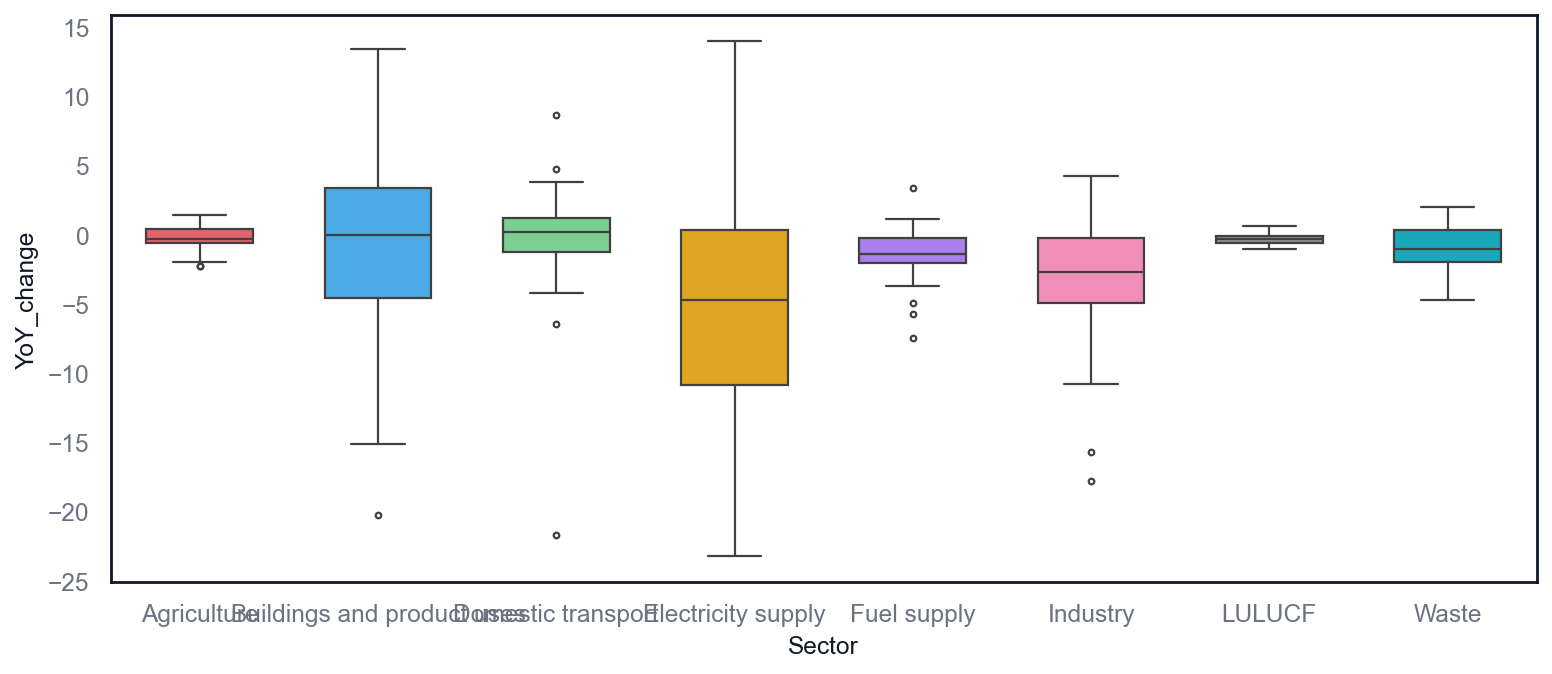

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

COL_RED   = "#fa4d56"
COL_GREEN = "#6fdc8c"
COL_BLUE  = "#33b1ff"
COL_GRAY  = "#6b7280"
COL_DARK  = "#111827"

SECTOR_PALETTE = [COL_RED, COL_BLUE, COL_GREEN, "#ffb000", "#a56eff", "#ff7eb6", "#8a8f98", "#00bcd4"]

def set_clean_theme():
    sns.set_theme(
        style="white",
        context="notebook",
        rc={
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "axes.edgecolor": COL_DARK,
            "axes.labelcolor": COL_DARK,
            "text.color": COL_DARK,
            "xtick.color": COL_GRAY,
            "ytick.color": COL_GRAY,
            "axes.grid": False,
            "grid.alpha": 0.0,
            "font.size": 10,
            "axes.titlesize": 13,
            "axes.labelsize": 11,
            "figure.dpi": 160,
            "savefig.dpi": 300,
        }
    )

def clean_ax(ax):
    ax.grid(False)
    sns.despine(ax=ax, top=True, right=True)
    ax.margins(x=0.01)
    ax.tick_params(labelsize=9)

def sparse_xticks(ax, xvals, step=5):
    xvals = np.asarray(xvals)
    if len(xvals) == 0:
        return
    idx = np.arange(0, len(xvals), step)
    ax.set_xticks(xvals[idx])
    ax.set_xticklabels([str(int(v)) for v in xvals[idx]])

set_clean_theme()

BASE_YEAR = 1990

if "Year_idx" not in territorial.columns:
    territorial = territorial.copy()
    territorial = territorial[territorial["Year"] >= BASE_YEAR]
    territorial["Year_idx"] = territorial["Year"] - BASE_YEAR + 1

sector_col = "Territorial Emissions Statistics sector"
value_col = "Emissions (MtCO2e)"

if "pivot_sec" not in globals():
    pivot_sec = (
        territorial.groupby(["Year", "Year_idx", sector_col])[value_col]
        .sum()
        .reset_index()
        .pivot(index="Year", columns=sector_col, values=value_col)
        .sort_index()
    )

if "corr_matrix" not in globals():
    corr_matrix = pivot_sec.corr()

t = (pivot_sec.index.values - pivot_sec.index.min()) + 1
year0 = int(pivot_sec.index.min())

# Plot 1: Total territorial emissions over time
tot = (
    territorial.groupby(["Year", "Year_idx"])[value_col]
    .sum()
    .reset_index()
    .sort_values("Year")
)
fig, ax = plt.subplots(figsize=(10.5, 3.6))
sns.lineplot(data=tot, x="Year_idx", y=value_col, ax=ax, color=COL_BLUE, linewidth=2.6)
ax.set_title("UK Territorial Greenhouse Gas Emissions Over Time", pad=10)
ax.set_xlabel(f"Year index ({BASE_YEAR} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, tot["Year_idx"].values, step=5)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 2: Sector emissions trajectories over time
sec_long = (
    territorial.groupby([sector_col, "Year", "Year_idx"])[value_col]
    .sum()
    .reset_index()
    .sort_values([sector_col, "Year"])
)
fig, ax = plt.subplots(figsize=(11.5, 5.2))
sns.lineplot(
    data=sec_long,
    x="Year_idx",
    y=value_col,
    hue=sector_col,
    palette=SECTOR_PALETTE,
    linewidth=2.0,
    ax=ax
)
ax.set_title("Sector Emissions Over Time (Territorial Total)", pad=10)
ax.set_xlabel(f"Year index ({BASE_YEAR} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, np.sort(sec_long["Year_idx"].unique()), step=5)
clean_ax(ax)
ax.legend(frameon=False, ncol=2, bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9, title=None)
plt.tight_layout()
plt.show()

# Plot 3: Correlation heatmap across sectors
cmap = LinearSegmentedColormap.from_list("rgb_custom", [COL_RED, "white", COL_BLUE], N=256)
fig, ax = plt.subplots(figsize=(7.8, 6.8))
sns.heatmap(
    corr_matrix.astype(float),
    vmin=-1, vmax=1,
    cmap=cmap,
    annot=True, fmt=".2f",
    annot_kws={"size": 8, "color": COL_DARK},
    cbar_kws={"label": "Correlation"},
    linewidths=0.0,
    ax=ax
)
ax.set_title("Correlation Matrix (Sectors)", pad=10)
clean_ax(ax)
plt.tight_layout()
plt.show()

yoy = pivot_sec.diff().dropna()

# Plot 4: Histogram of YoY changes for two sectors
candidates = ["Electricity supply", "Domestic transport", "Industry", "Buildings and product uses"]
chosen = [c for c in candidates if c in yoy.columns][:2]
if len(chosen) < 2:
    chosen = yoy.columns[:2].tolist()

fig, ax = plt.subplots(figsize=(10.5, 3.6))
sns.histplot(yoy[chosen[0]], bins=20, kde=False, color=COL_RED, alpha=0.35, edgecolor=None, ax=ax, label=chosen[0])
if len(chosen) > 1:
    sns.histplot(yoy[chosen[1]], bins=20, kde=False, color=COL_GREEN, alpha=0.35, edgecolor=None, ax=ax, label=chosen[1])
ax.set_title("Distribution of Year-over-Year Emission Changes", pad=10)
ax.set_xlabel("YoY change (MtCO2e)")
ax.set_ylabel("Count")
ax.legend(frameon=False, fontsize=9)
clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 5: Boxplot of YoY changes across sectors
yoy_long = yoy.reset_index().melt(id_vars=["Year"], var_name="Sector", value_name="YoY_change")
sector_order = list(yoy.columns)

fig, ax = plt.subplots(figsize=(11.5, 4.6))
sns.boxplot(
    data=yoy_long,
    x="Sector",
    y="YoY_change",
    order=sector_order,
    hue="Sector",
    palette=SECTOR_PALETTE,
    dodge=False,
    width=0.6,
    fliersize=2.5,
    linewidth=1.0,
    ax=ax
)
ax.legend_.remove()

for artist in ax.artists:
    artist.set_alpha(0.40)

ax.set_title("Boxplot: YoY Emission Changes by Sector", pad=10)
ax.set_xlabel("")
ax.set_ylabel("YoY change (MtCO2e)")
ax.tick_params(axis="x", rotation=90, labelsize=9)

clean_ax(ax)
plt.tight_layout()
plt.show()

# Plot 6: Scatter with regression line for strongest correlated sector pairs
for (s1, s2), r in top_pairs.items():
    fig, ax = plt.subplots(figsize=(5.6, 4.8))
    sns.regplot(
        x=pivot_sec[s1].values,
        y=pivot_sec[s2].values,
        scatter_kws={"s": 42, "alpha": 0.75, "color": COL_BLUE, "edgecolor": "none"},
        line_kws={"linewidth": 2.2, "color": COL_RED},
        ax=ax
    )
    ax.set_title(f"{s1} vs {s2} (r = {r:.3f})", pad=10)
    ax.set_xlabel(f"{s1} (MtCO2e)")
    ax.set_ylabel(f"{s2} (MtCO2e)")
    clean_ax(ax)
    plt.tight_layout()
    plt.show()

# Plot 7: Stacked area showing sector composition over time
fig, ax = plt.subplots(figsize=(11.5, 5.2))
ax.stackplot(
    t,
    np.vstack([pivot_sec[c].values for c in pivot_sec.columns]),
    labels=pivot_sec.columns,
    alpha=0.75,
    colors=[SECTOR_PALETTE[i % len(SECTOR_PALETTE)] for i in range(len(pivot_sec.columns))]
)
ax.set_title("Sector Composition of Territorial Emissions Over Time", pad=10)
ax.set_xlabel(f"Year index ({year0} = 1)")
ax.set_ylabel("Emissions (MtCO2e)")
sparse_xticks(ax, t, step=5)
clean_ax(ax)
ax.legend(frameon=False, ncol=2, bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9, title=None)
plt.tight_layout()
plt.show()